In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [2]:
# Load Train, Validation, Test Dataset
train_dataset = pd.read_csv('/kaggle/input/clinical-datasets/Google_Translated/Google_Translated/MIMIC_III/MP_IN_adm_train.csv')
val_dataset = pd.read_csv('/kaggle/input/clinical-datasets/Google_Translated/Google_Translated/MIMIC_III/MP_IN_adm_val.csv')
test_dataset = pd.read_csv('/kaggle/input/clinical-datasets/Google_Translated/Google_Translated/MIMIC_III/MP_IN_adm_test.csv')

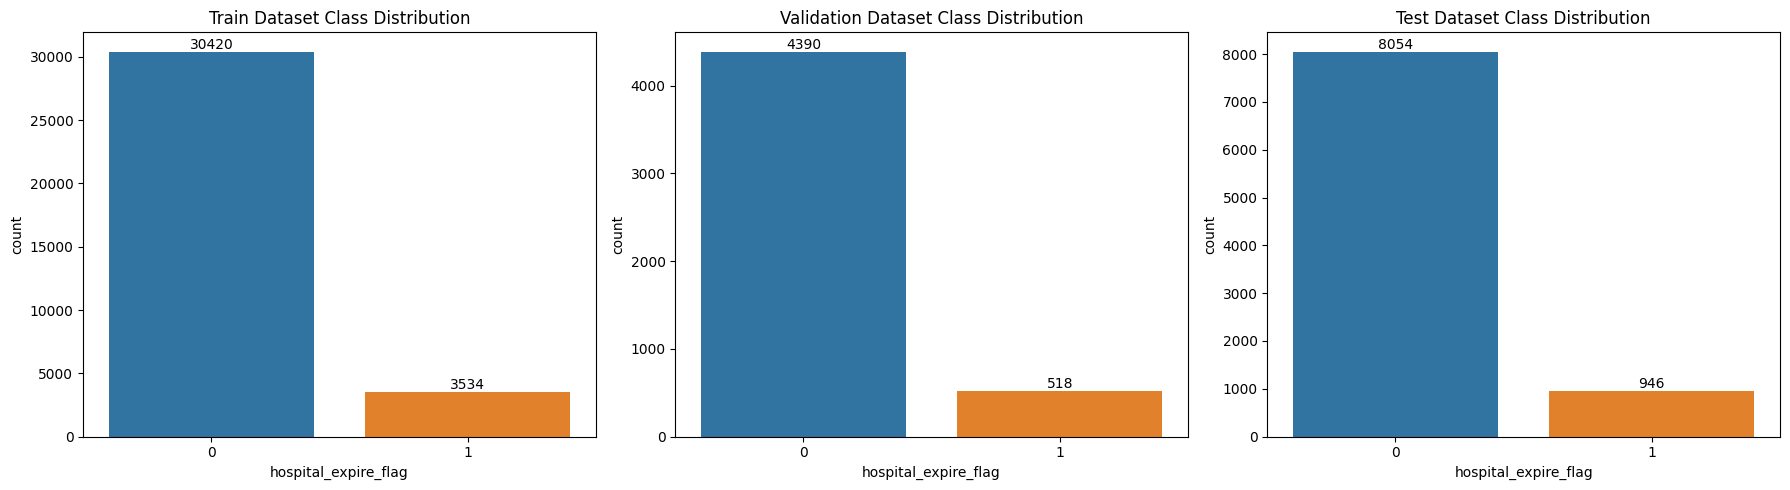

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Function to add count labels above bars
def add_count_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.5,  # Positioning the text
                f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Train Set
sns.countplot(x='hospital_expire_flag', data=train_dataset, ax=axes[0])
axes[0].set_title("Train Dataset Class Distribution")
add_count_labels(axes[0])

# Validation Set
sns.countplot(x='hospital_expire_flag', data=val_dataset, ax=axes[1])
axes[1].set_title("Validation Dataset Class Distribution")
add_count_labels(axes[1])

# Test Set
sns.countplot(x='hospital_expire_flag', data=test_dataset, ax=axes[2])
axes[2].set_title("Test Dataset Class Distribution")
add_count_labels(axes[2])

# Display the plots
plt.tight_layout()
plt.show()

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        
        # Initial attention scores (for learning importance of each model)
        self.attention1 = nn.Parameter(torch.tensor(1.0))  # Model 1 attention
        self.attention2 = nn.Parameter(torch.tensor(1.0))  # Model 2 attention
        
        # Model weight parameters (initialized to 1 for simplicity)
        self.weight1 = nn.Parameter(torch.tensor(1.0))
        self.weight2 = nn.Parameter(torch.tensor(1.0))
        
        # Parameters to keep track of performance (boosting mechanism)
        self.alpha1 = nn.Parameter(torch.tensor(0.5))
        self.alpha2 = nn.Parameter(torch.tensor(0.5))
    
    def forward(self, input_ids, attention_mask, loss1=None, loss2=None):
        # Get the model outputs
        outputs1 = self.model1(input_ids, attention_mask=attention_mask)[0]
        outputs2 = self.model2(input_ids, attention_mask=attention_mask)[0]
        
        # Apply softmax to normalize the model weights
        weights = torch.softmax(torch.stack([self.weight1, self.weight2]), dim=0)
        
        # Apply softmax to normalize the attention weights (to focus on the important model outputs)
        attention_weights = torch.softmax(torch.stack([self.attention1, self.attention2]), dim=0)
        
        # Weighted sum of the model outputs (with attention)
        weighted_output = attention_weights[0] * (weights[0] * outputs1) + attention_weights[1] * (weights[1] * outputs2)
        
        # Boosting: Update model weights based on model performance
        if loss1 is not None and loss2 is not None:
            # For simplicity, assume boosting updates are based on model performance
            # (i.e., inverse of loss) to increase focus on harder examples
            self.alpha1.data = self.alpha1.data * torch.exp(-loss1)
            self.alpha2.data = self.alpha2.data * torch.exp(-loss2)

            # Adjust model weights based on boosting factors
            self.weight1.data = self.weight1.data + self.alpha1
            self.weight2.data = self.weight2.data + self.alpha2

        return weighted_output

In [5]:
from transformers import AutoModelForSequenceClassification, AutoConfig

# Specify the dropout rate in the configuration
config = AutoConfig.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', 
                                    num_labels=2, 
                                    hidden_dropout_prob=0.2, 
                                    attention_probs_dropout_prob=0.2)

# Load the pre-trained model with the specified configuration
model1 = AutoModelForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', config=config)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from transformers import AutoModelForSequenceClassification, AutoConfig

# Specify the dropout rate in the configuration
config = AutoConfig.from_pretrained('emilyalsentzer/Bio_Discharge_Summary_BERT', 
                                    num_labels=2, 
                                    hidden_dropout_prob=0.2, 
                                    attention_probs_dropout_prob=0.2)

# Load the pre-trained model with the specified configuration
model2 = AutoModelForSequenceClassification.from_pretrained('emilyalsentzer/Bio_Discharge_Summary_BERT', config=config)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_Discharge_Summary_BERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import AutoTokenizer

# Choose a tokenizer
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_Discharge_Summary_BERT')

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [8]:
train_dataset = train_dataset.dropna(subset=['text']).reset_index(drop=True)

In [9]:
# Apply the tokenizer to the training, validation, and test datasets
train_encodings = tokenizer(train_dataset['text'].tolist(), truncation=True, padding=True, max_length = 512)
val_encodings = tokenizer(val_dataset['text'].tolist(), truncation=True, padding=True,  max_length = 512)
test_encodings = tokenizer(test_dataset['text'].tolist(), truncation=True, padding=True , max_length = 512)

In [10]:
# Create a Dataset for PyTorch
class LosDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
train_dataset = LosDataset(train_encodings, train_dataset['hospital_expire_flag'].tolist())
val_dataset = LosDataset(val_encodings, val_dataset['hospital_expire_flag'].tolist())
test_dataset = LosDataset(test_encodings, test_dataset['hospital_expire_flag'].tolist())

In [12]:
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from tqdm import tqdm
from torch import nn
import numpy as np

# Initialize the Ensemble Model
ensemble_model = EnsembleModel(model1, model2)

In [13]:
import os

# list all files in the current directory
files = os.listdir('.')

# filter the ones that start with 'MP_ENEMBLE_TEACHER'
core_models = [f for f in files if f.startswith('MP_ENEMBLE_TEACHER')]

if core_models:
    print("Found models starting with 'MP_ENEMBLE_TEACHER':")
    for model in core_models:
        print(model)
        
    # get the first (and supposedly only) model
    model_path = core_models[1]

    # load the model state
    ensemble_model.load_state_dict(torch.load(model_path))
    print("Loaded Model")
else:
    print("No models found starting with 'MP_ENEMBLE_TEACHER'.")

No models found starting with 'MP_ENEMBLE_TEACHER'.


In [14]:
ensemble_model

EnsembleModel(
  (model1): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.2, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=

In [15]:
# Push the model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model = ensemble_model.to(device)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [17]:
epochs = 100
best_roc_auc = 0
min_delta = 0.0001
early_stopping_count = 0
early_stopping_patience = 5
gradient_accumulation_steps = 10
best_model_path = "best_model.pth"

# Set the optimizer
optimizer = AdamW(ensemble_model.parameters(), lr=1e-5, weight_decay=0.01)

# Set the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=50, 
    num_training_steps=len(train_loader) * epochs // gradient_accumulation_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Class Weights:
Class 0: Weight 0.5580703484549638
Class 1: Weight 4.805123124823097


100%|██████████| 2454/2454 [02:44<00:00, 14.92it/s]


Epoch: 1/100, Training Loss: 0.42620781128732915, Validation Loss: 0.3794853561349098
Accuracy: 0.9228912460287743, Recall: 0.2059482435009419, Precision: 0.6769023364443115, F1: 0.3012239273726191, Micro F1: 0.3012239273726191, Macro Roc Auc: 0.8532019134567407


100%|██████████| 2454/2454 [02:44<00:00, 14.92it/s]


Epoch: 2/100, Training Loss: 0.3627362215148485, Validation Loss: 0.36800747081301893
Accuracy: 0.9247740576467403, Recall: 0.21326060250669474, Precision: 0.7322475911233668, F1: 0.31418763710386827, Micro F1: 0.31418763710386827, Macro Roc Auc: 0.8668902356551809


100%|██████████| 2454/2454 [02:45<00:00, 14.83it/s]


Epoch: 3/100, Training Loss: 0.329834603292447, Validation Loss: 0.35170979153504556
Accuracy: 0.9202217352606067, Recall: 0.41432645788930444, Precision: 0.5988189567835593, F1: 0.48707700522243286, Micro F1: 0.48707700522243286, Macro Roc Auc: 0.8743567729578535


100%|██████████| 2454/2454 [02:45<00:00, 14.83it/s]


Epoch: 4/100, Training Loss: 0.2881687894350559, Validation Loss: 0.3902765441205453
Accuracy: 0.9232051368239493, Recall: 0.28245944729622513, Precision: 0.6514284680743553, F1: 0.38395877096813436, Micro F1: 0.38395877096813436, Macro Roc Auc: 0.8655720374834942
EarlyStopping counter: 1 out of 5


100%|██████████| 2454/2454 [02:43<00:00, 14.98it/s]


Epoch: 5/100, Training Loss: 0.24482178740706043, Validation Loss: 0.3912676405791609
Accuracy: 0.9142452317822409, Recall: 0.4316857458978024, Precision: 0.552247049966442, F1: 0.48336950408834944, Micro F1: 0.48336950408834944, Macro Roc Auc: 0.8611991979900571
EarlyStopping counter: 2 out of 5


100%|██████████| 2454/2454 [02:44<00:00, 14.94it/s]


Epoch: 6/100, Training Loss: 0.19744944486036567, Validation Loss: 0.44413299627172115
Accuracy: 0.9095177273967381, Recall: 0.3947490781508616, Precision: 0.5132734450093771, F1: 0.44501065892566216, Micro F1: 0.44501065892566216, Macro Roc Auc: 0.853265200634469
EarlyStopping counter: 3 out of 5


100%|██████████| 2454/2454 [02:44<00:00, 14.88it/s]


Epoch: 7/100, Training Loss: 0.15965682696594902, Validation Loss: 0.495005284288322
Accuracy: 0.9134578811787529, Recall: 0.40065563322178055, Precision: 0.5422649061293263, F1: 0.45909838286359284, Micro F1: 0.45909838286359284, Macro Roc Auc: 0.8460260391104232
EarlyStopping counter: 4 out of 5


100%|██████████| 2454/2454 [02:44<00:00, 14.90it/s]


Epoch: 8/100, Training Loss: 0.12275966725661563, Validation Loss: 0.6784898231506478
Accuracy: 0.9164486124084636, Recall: 0.26911292849412083, Precision: 0.5473748497805968, F1: 0.35392212351401675, Micro F1: 0.35392212351401675, Macro Roc Auc: 0.8254941573318273
EarlyStopping counter: 5 out of 5
Early stopping


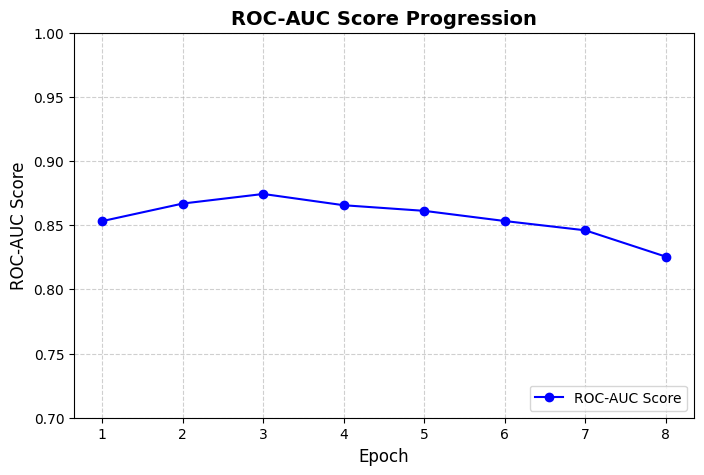

ROC-AUC values per epoch saved to 'roc_auc_per_epoch.csv'


In [18]:
import torch
from torch.nn import functional as F
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute class weights
classes = np.unique(train_dataset.labels)  # Get unique class labels
class_weights = compute_class_weight('balanced', classes=classes, y=train_dataset.labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Print class weights with corresponding class names
print("Class Weights:")
for cls, weight in zip(classes, class_weights):
    print(f"Class {cls}: Weight {weight}")

roc_auc_values = []
# Training loop
for epoch in range(0, epochs):
    ensemble_model.train()
    train_loss = 0
    for step, batch in enumerate(tqdm(train_loader)):
        optimizer.zero_grad() if step % gradient_accumulation_steps == 0 else None
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = ensemble_model(input_ids, attention_mask)

        # Apply cost-sensitive loss
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fn(outputs, labels)

        (loss / gradient_accumulation_steps).backward()
        train_loss += loss.item()
        
        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_loader):
            optimizer.step()
            scheduler.step()

    # Validation
    ensemble_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = ensemble_model(input_ids, attention_mask)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            val_preds.append(F.softmax(outputs, dim=1).cpu().numpy())
            val_labels.append(labels.cpu().numpy())

    val_preds = np.concatenate(val_preds)
    val_labels = np.concatenate(val_labels)
    val_loss /= len(val_loader)
    train_loss /= len(train_loader)

    print(f'Epoch: {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # Calculate evaluation metrics
    val_preds_class = np.argmax(val_preds, axis=1)
    accuracy = accuracy_score(val_labels, val_preds_class) 
    recall = recall_score(val_labels, val_preds_class) 
    precision = precision_score(val_labels, val_preds_class) 
    f1 = f1_score(val_labels, val_preds_class) 
    micro_f1 = f1_score(val_labels, val_preds_class) 
    macro_roc_auc = roc_auc_score(val_labels, val_preds[:, 1]) 

    print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1: {f1}, Micro F1: {micro_f1}, Macro Roc Auc: {macro_roc_auc}')
    # Store the ROC-AUC value for this epoch
    roc_auc_values.append(macro_roc_auc)

    # Implement early stopping
    if epoch > 0 and macro_roc_auc - best_roc_auc < min_delta:
        early_stopping_count += 1
        print(f'EarlyStopping counter: {early_stopping_count} out of {early_stopping_patience}')
        if early_stopping_count >= early_stopping_patience:
            print('Early stopping')
            break
    else:
        best_roc_auc = macro_roc_auc
        early_stopping_count = 0
        torch.save(ensemble_model.state_dict(), f"MP_ENEMBLE_TEACHER_epoch_{epoch}_roc_{best_roc_auc:.4f}.pth")

# After training, plot the ROC-AUC curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(roc_auc_values) + 1), roc_auc_values, marker='o', linestyle='-', color='b', label='ROC-AUC Score')

# Enhancing readability
plt.title('ROC-AUC Score Progression', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, loc='lower right')
plt.ylim(0.7, 1.0)  # Adjust y-axis range if necessary

plt.show()

# Convert the list of ROC-AUC values and epochs to a DataFrame
roc_auc_df = pd.DataFrame(roc_auc_values)

# Save the DataFrame to a CSV file
roc_auc_df.to_csv('roc_auc_per_epoch.csv', index=False)

print("ROC-AUC values per epoch saved to 'roc_auc_per_epoch.csv'")

In [19]:
import os

# list all files in the current directory
files = os.listdir('.')

# filter the ones that start with 'MP_ENEMBLE_TEACHER'
core_models = sorted([f for f in files if f.startswith('MP_ENEMBLE_TEACHER')])

if core_models:
    print("Found models starting with 'MP_ENEMBLE_TEACHER':")
    for model in core_models:
        print(model)
        
    # get the first (and supposedly only) model
    model_path = core_models[-1]

    # load the model state
    ensemble_model.load_state_dict(torch.load(model_path))
    print("Loaded Model")
else:
    print("No models found starting with 'MP_ENEMBLE_TEACHER'.")

Found models starting with 'MP_ENEMBLE_TEACHER':
MP_ENEMBLE_TEACHER_epoch_0_roc_0.8532.pth
MP_ENEMBLE_TEACHER_epoch_1_roc_0.8669.pth
MP_ENEMBLE_TEACHER_epoch_2_roc_0.8744.pth


<ipython-input-19-df0afb7ac0b5>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ensemble_model.load_state_dict(torch.load(model_path))


Loaded Model


In [20]:
# Put the model in evaluation mode
ensemble_model.eval()

# Initialize lists to store predictions and true labels
test_preds = []
test_labels = []

# Iterate over test data
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = ensemble_model(input_ids, attention_mask)
        test_preds.append(F.softmax(outputs, dim=1).cpu().numpy())
        test_labels.append(labels.cpu().numpy())

100%|██████████| 4500/4500 [05:01<00:00, 14.91it/s]


In [21]:
test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

# Calculate metrics
test_preds_class = np.argmax(test_preds, axis=1)
accuracy = accuracy_score(test_labels, test_preds_class) 
recall = recall_score(test_labels, test_preds_class) 
precision = precision_score(test_labels, test_preds_class) 
f1 = f1_score(test_labels, test_preds_class) 
micro_f1 = f1_score(test_labels, test_preds_class) 
macro_roc_auc = roc_auc_score(test_labels, test_preds[:, 1]) 

print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1: {f1}, Micro F1: {micro_f1}, Macro Roc Auc: {macro_roc_auc}')

Accuracy: 0.9237644020634653, Recall: 0.4087832293744749, Precision: 0.6303627358417917, F1: 0.4922078636303194, Micro F1: 0.4922078636303194, Macro Roc Auc: 0.871663276634911
